In [1]:
import cv2
import os
import glob
from PIL import Image

In [13]:
def get_relative_file_paths(directory, root_folder):
    root_folder_abs_path = os.path.abspath(root_folder)
    all_files = glob.glob(os.path.join(directory, '*/*/*'), recursive=True)
    relative_paths = [
        os.path.relpath(file, root_folder_abs_path)
        for file in all_files if os.path.isfile(file)
    ]
    shotgun_files = glob.glob(os.path.join(directory, '*/shotgun/*'), recursive=True)
    shotgun_relative_paths = [
        os.path.relpath(file, root_folder_abs_path)
        for file in shotgun_files if os.path.isfile(file)
    ]

    driver_files = glob.glob(os.path.join(directory, '*/driver/*'), recursive=True)
    driver_relative_paths = [
        os.path.relpath(file, root_folder_abs_path)
        for file in driver_files if os.path.isfile(file)
    ]

    shotgun_data = {}
    for path in shotgun_relative_paths:
        shotgun_data[path] = 0

    driver_data = {}
    for path in driver_relative_paths:
        driver_data[path] = 1

    all_data = {**driver_data, **shotgun_data}


    print('All files:', len(relative_paths))
    print('Class driver:', len(driver_relative_paths))
    print('Class shotgun:', len(shotgun_relative_paths))

    print('driver Data:', driver_data)
    print('shotgun Data:', shotgun_data)
    print('All Data:', all_data)
    
    return all_data

directory = '../input/data/images/'  
root_folder = '../'

all_data = get_relative_file_paths(directory, root_folder)

All files: 587
Class driver: 286
Class shotgun: 301
driver Data: {'input/data/images/18/driver/frame_00008 copy 2.jpg': 1, 'input/data/images/18/driver/frame_00014 copy 2.jpg': 1, 'input/data/images/18/driver/frame_00000 copy 2.jpg': 1, 'input/data/images/18/driver/frame_00012.jpg': 1, 'input/data/images/18/driver/frame_00006.jpg': 1, 'input/data/images/18/driver/frame_00016 copy 2.jpg': 1, 'input/data/images/18/driver/frame_00007.jpg': 1, 'input/data/images/18/driver/frame_00013.jpg': 1, 'input/data/images/18/driver/frame_00005.jpg': 1, 'input/data/images/18/driver/frame_00010.jpg': 1, 'input/data/images/18/driver/frame_00004.jpg': 1, 'input/data/images/18/driver/frame_00003.jpg': 1, 'input/data/images/18/driver/frame_00002.jpg': 1, 'input/data/images/18/driver/frame_00001 copy 2.jpg': 1, 'input/data/images/18/driver/frame_00025.jpg': 1, 'input/data/images/18/driver/frame_00019.jpg': 1, 'input/data/images/18/driver/frame_00009 copy 2.jpg': 1, 'input/data/images/18/driver/frame_00020.j

In [18]:
import numpy as np
import torch
from torchvision import transforms
from sklearn.model_selection import train_test_split
from torch.utils.data import TensorDataset, DataLoader
from PIL import Image
import os


# Data augmentation transforms
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((256, 256)),
    transforms.RandomHorizontalFlip(),
])

def load_and_augment_images(all_data, save_dir='../input/data/steering_wheel/augmented_images'):
    root_dir = '../'
    augmented_images = []
    augmented_labels = []

    if not os.path.exists(save_dir):
        os.makedirs(save_dir)

    for idx, (file_path, label) in enumerate(all_data.items()):
        img = Image.open(os.path.join(root_dir, file_path))

        transformed_img = transform(img)

        augmented_images.append(transformed_img)
        augmented_labels.append(label)
    
    print('Len augmented images:', len(augmented_images))
    print('Len augmented augmented_labels:', len(augmented_labels))

    return torch.stack(augmented_images), np.array(augmented_labels)



X_augmented, y_augmented = load_and_augment_images(all_data)

# Split dataset into train, validation, and test sets
test_size = 0.2
random_state = 42

X_train, X_val, y_train, y_val = train_test_split(X_augmented, y_augmented, test_size=0.1, random_state=random_state)

X_train, X_val = torch.tensor(X_train), torch.tensor(X_val)
y_train, y_val = torch.tensor(y_train), torch.tensor(y_val)

# Print shapes
print(f"X_train shape: {X_train.shape}, y_train shape: {y_train.shape}")
print(f"X_val shape: {X_val.shape}, y_val shape: {y_val.shape}")


Len augmented images: 587
Len augmented augmented_labels: 587
X_train shape: torch.Size([528, 3, 128, 128]), y_train shape: torch.Size([528])
X_val shape: torch.Size([59, 3, 128, 128]), y_val shape: torch.Size([59])


/var/folders/pc/5jkxyq3s4xb26zff0_pshj400000gn/T/ipykernel_1445/1636165495.py:48: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_train, X_val = torch.tensor(X_train), torch.tensor(X_val)


In [37]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader

input_shape = (3, 256, 256)

class SimpleCNN(nn.Module):
    def __init__(self, num_classes):
        super(SimpleCNN, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        # Calculate the shape of the output after conv layers to feed into fully connected layers
        self.flatten_dim = self._get_flatten_dim(input_shape)
        self.classifier = nn.Sequential(
            nn.Linear(self.flatten_dim, 128),
            nn.ReLU(inplace=True),
            nn.Linear(128, num_classes)
        )

    def _get_flatten_dim(self, shape):
        x = torch.randn(1, *shape)
        x = self.features(x)
        return x.view(1, -1).size(1)

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)  # flatten the tensor
        x = self.classifier(x)
        return x

# Initialize the model
num_classes = 2
model = SimpleCNN(num_classes)
print(model)


SimpleCNN(
  (features): Sequential(
    (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Linear(in_features=32768, out_features=128, bias=True)
    (1): ReLU(inplace=True)
    (2): Linear(in_features=128, out_features=2, bias=True)
  )
)


In [38]:
# Convert numpy arrays to PyTorch tensors
X_train_tensor = torch.Tensor(X_train)
y_train_tensor = torch.LongTensor(y_train)
X_val_tensor = torch.Tensor(X_val)
y_val_tensor = torch.LongTensor(y_val)

# Create DataLoader instances
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
val_dataset = TensorDataset(X_val_tensor, y_val_tensor)

batch_size = 16
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size)

In [39]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [40]:
from tqdm import tqdm

def calculate_accuracy(outputs, labels):
    _, predicted = torch.max(outputs, 1)
    correct = (predicted == labels).sum().item()
    accuracy = correct / labels.size(0)
    return accuracy

train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=20, patience=5):
    
    best_val_loss = np.inf
    no_improvement_count = 0
    
    for epoch in range(num_epochs):
        model.train()
        train_loss = 0.0
        train_correct = 0
        train_total = 0
        
        for inputs, labels in tqdm(train_loader, desc=f'Epoch {epoch+1}/{num_epochs}', leave=False):
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            train_loss += loss.item() * inputs.size(0)
            train_total += labels.size(0)
            train_correct += (torch.argmax(outputs, dim=1) == labels).sum().item()
        
        train_loss = train_loss / len(train_loader.dataset)
        train_accuracy = train_correct / train_total
        train_losses.append(train_loss)
        train_accuracies.append(train_accuracy)
        
        model.eval()
        val_loss = 0.0
        val_correct = 0
        val_total = 0
        
        with torch.no_grad():
            for inputs, labels in val_loader:
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                val_loss += loss.item() * inputs.size(0)
                val_total += labels.size(0)
                val_correct += (torch.argmax(outputs, dim=1) == labels).sum().item()
        
        val_loss = val_loss / len(val_loader.dataset)
        val_accuracy = val_correct / val_total
        val_losses.append(val_loss)
        val_accuracies.append(val_accuracy)
        
        print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, Train Acc: {train_accuracy:.4f}, Val Acc: {val_accuracy:.4f}')
        
        # Early stopping
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            no_improvement_count = 0
        else:
            no_improvement_count += 1
        
        if no_improvement_count >= patience:
            print(f'Early stopping after epoch {epoch+1}')
            break

In [41]:
train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=20, patience=5)

Epoch 1/20, Train Loss: 0.6058, Val Loss: 0.4279, Train Acc: 0.6780, Val Acc: 0.8305


Epoch 2/20, Train Loss: 0.2445, Val Loss: 0.2332, Train Acc: 0.8996, Val Acc: 0.8983


Epoch 3/20, Train Loss: 0.1030, Val Loss: 0.1050, Train Acc: 0.9602, Val Acc: 0.9492


Epoch 4/20, Train Loss: 0.0344, Val Loss: 0.0864, Train Acc: 0.9924, Val Acc: 0.9492


Epoch 5/20, Train Loss: 0.0164, Val Loss: 0.0888, Train Acc: 0.9962, Val Acc: 0.9661


Epoch 6/20, Train Loss: 0.0099, Val Loss: 0.0786, Train Acc: 1.0000, Val Acc: 0.9661


Epoch 7/20, Train Loss: 0.0022, Val Loss: 0.0828, Train Acc: 1.0000, Val Acc: 0.9661


Epoch 8/20, Train Loss: 0.0017, Val Loss: 0.0753, Train Acc: 1.0000, Val Acc: 0.9661


Epoch 9/20, Train Loss: 0.0012, Val Loss: 0.0754, Train Acc: 1.0000, Val Acc: 0.9661


Epoch 10/20, Train Loss: 0.0006, Val Loss: 0.0571, Train Acc: 1.0000, Val Acc: 0.9661


Epoch 11/20, Train Loss: 0.0005, Val Loss: 0.0585, Train Acc: 1.0000, Val Acc: 0.9661


Epoch 12/20, Train Loss: 0.0005, Val Loss: 0.0647, Train Acc: 1.0000, Val Acc: 0.9492


Epoch 13/20, Train Loss: 0.0003, Val Loss: 0.0568, Train Acc: 1.0000, Val Acc: 0.9661


Epoch 14/20, Train Loss: 0.0003, Val Loss: 0.0552, Train Acc: 1.0000, Val Acc: 0.9661


Epoch 15/20, Train Loss: 0.0002, Val Loss: 0.0525, Train Acc: 1.0000, Val Acc: 0.9661


Epoch 16/20, Train Loss: 0.0002, Val Loss: 0.0503, Train Acc: 1.0000, Val Acc: 0.9661


Epoch 17/20, Train Loss: 0.0002, Val Loss: 0.0471, Train Acc: 1.0000, Val Acc: 0.9661


Epoch 18/20, Train Loss: 0.0002, Val Loss: 0.0568, Train Acc: 1.0000, Val Acc: 0.9661


Epoch 19/20, Train Loss: 0.0002, Val Loss: 0.0554, Train Acc: 1.0000, Val Acc: 0.9492


Epoch 20/20, Train Loss: 0.0001, Val Loss: 0.0517, Train Acc: 1.0000, Val Acc: 0.9661


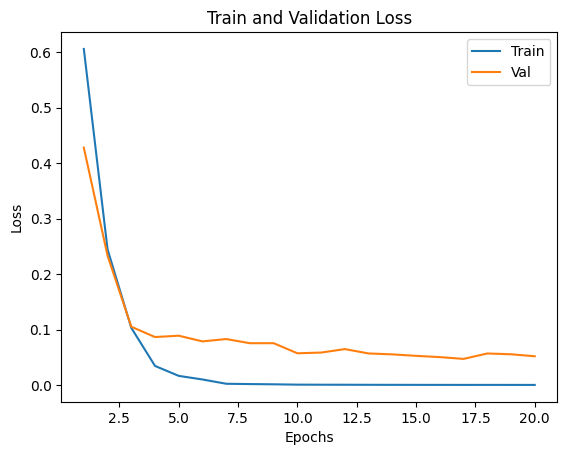

In [42]:
import matplotlib.pyplot as plt

plt.plot(range(1, len(train_losses)+1), train_losses, label='Train')
plt.plot(range(1, len(val_losses)+1), val_losses, label='Val')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Train and Validation Loss')
plt.legend()
plt.show()

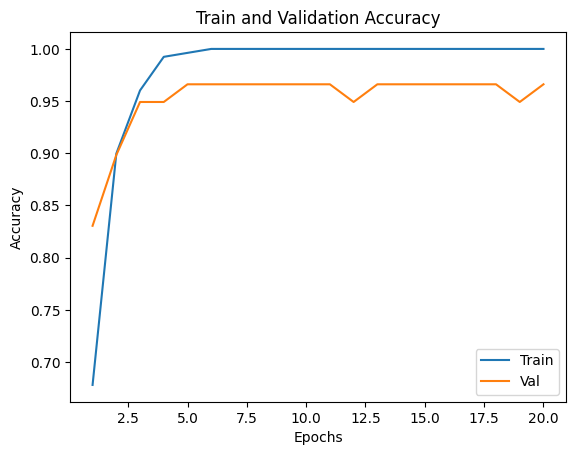

In [43]:
plt.plot(range(1, len(train_accuracies)+1), train_accuracies, label='Train')
plt.plot(range(1, len(val_accuracies)+1), val_accuracies, label='Val')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Train and Validation Accuracy')
plt.legend()
plt.show()

In [44]:
model_path = '../model/trained_model/simple_cnn_model.pth'
torch.save(model, model_path)

SimpleCNN(
  (features): Sequential(
    (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Linear(in_features=32768, out_features=128, bias=True)
    (1): ReLU(inplace=True)
    (2): Linear(in_features=128, out_features=2, bias=True)
  )
)


In [47]:
torch.save({
    'model_state_dict': model.state_dict(),
}, '../model/trained_model/simple_cnn_model.pth')